## Conclusion
##### Dataset Summary
- The `train_essays.csv` (row count=1378) file reveals a significant class imbalance, with student-written essays far outnumbering those generated by LLMs (3 essays, 2 from prompt_id=1, 1 from prompt_id=0)
- `test_essays.csv` (row count=3): Aligns with the training set but lacks target labels. Use for submission.
- `train_prompts.csv` (row count=2): Contains only 2 distinct prompts, each with unique instructions and source texts (that may influencing essay styles)
- `sample_submission.csv`: Guides the expected format for model predictions to be evaluated.

##### Insights 
- Student essays display a broader range of lengths and complexities compared to the more succinct LLM-generated texts.
- Text analysis reveals potential differentiators in word usage between student and LLM-generated essays.
- Student Essays: Longer in length with richer vocabulary (avg. word count: 556.77; unique words: 275.33).
- LLM-Generated Essays: Shorter but use slightly longer words (avg. word count: 260.67; unique words: 146.33), hinting at a different lexical strategy.
- Essays show strong thematic alignment with prompts, evidenced by a perfect LSA coherence score.
- Frequent bi-grams such as 'electoral college' and 'presidential election' in both prompts and essays reveal a clear thematic connection, with essays often extending the discussion to broader societal issues.
- Keyword frequency analysis highlights prompt-driven vocabulary in essays, such as 'electoral' and 'vote'.
- Numerical analysis differentiates writing styles, with students preferring digits and LLMs using number words.


#### Text Metrics Analysis Summary

- **Student-Written Essays**:
  - Average word count: 556.77 words
  - Average unique word count: 275.33 unique words
  - Average sentence count: 30.06 sentences
  - Average word length: 4.69 characters

- **LLM-Generated Essays**:
  - Average word count: 260.67 words
  - Average unique word count: 146.33 unique words
  - Average sentence count: 13 sentences
  - Average word length: 4.94 characters

These metrics underscore the general tendency for student essays to be longer and more complex, while LLM-generated texts are more succinct but with a tendency towards longer words. Such distinctions in text characteristics can be instrumental in developing features that effectively differentiate between essay types.

#### Thematic Analysis
- **Coherence**: Using Latent Semantic Analysis (LSA), we find perfect thematic alignment (coherence score of 1.0) between essays and prompts, indicating focused and relevant student writing.
- **Bi-grams**: Common bi-grams like 'electoral college' and 'presidential election' appear in both prompts and essays, while essays also introduce related themes, showing students' engagement with broader societal issues.
- **Keywords**: A strong thematic match is observed between prompts and essays with keywords like 'electoral', 'college', and 'vote' being highly prevalent, suggesting that prompts effectively direct the essays' focus.

#### Digit Representation Analysis
- **Student Essays**: Preferentially use numerals over words to represent numbers, possibly indicating a less formal writing style.
- **LLM-Generated Essays**: Given the limited sample, LLMs seem to use number words more than numerals, a potential differentiator from student essays.


#### Possible Next Steps for Model Development

1. Augment the dataset with additional LLM-generated essays using techniques like synthetic data generation or oversampling to address class imbalance.
2. Explore a variety of machine learning algorithms, from traditional models to advanced deep learning networks, to identify the most effective approach.
3. Conduct comprehensive hyperparameter optimization to refine the performance of chosen models.

Have fun!

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


## Introduction

We have three main data files at our disposal:

- `train_essays.csv`: The training set with essays written by students and a few examples of LLM-generated essays.
- `test_essays.csv`: The test set with essays for which we need to predict whether they were generated by an LLM.
- `train_prompts.csv`: The prompts used to generate the essays, containing both the instructions and source texts.

Our first step is to load these files and get an intuitive feel for their content.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define file paths
train_essays_path = '/kaggle/input/llm-detect-ai-generated-text/train_essays.csv'
test_essays_path = '/kaggle/input/llm-detect-ai-generated-text/test_essays.csv'
train_prompts_path = '/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv'

# Load the data
train_essays_df = pd.read_csv(train_essays_path)
test_essays_df = pd.read_csv(test_essays_path)
train_prompts_df = pd.read_csv(train_prompts_path)

In [3]:
# Display the few rows of the training essays
train_essays_df.tail()

,id,prompt_id,text,generated
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0
1377,ffe1ca0d,0,Cars have been around since the 1800's and hav...,0


In [4]:
# Display the few rows of the test essays
test_essays_df.tail()

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [5]:
# Display the few rows of the train_prompts
train_prompts_df.tail()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


## Exploratory Data Analysis (EDA)

In [6]:
# Check for missing values in the datasets
missing_values_train = train_essays_df.isnull().sum()
print("missing_values_train:", missing_values_train)
missing_values_test = test_essays_df.isnull().sum()
print("\nmissing_values_train:", missing_values_train)
missing_values_prompts = train_prompts_df.isnull().sum()
print("\nmissing_values_prompts:", missing_values_prompts)

missing_values_train: id           0
prompt_id    0
text         0
generated    0
dtype: int64

missing_values_train: id           0
prompt_id    0
text         0
generated    0
dtype: int64

missing_values_prompts: prompt_id       0
prompt_name     0
instructions    0
source_text     0
dtype: int64


Understanding the balance of categories is fundamental in any classification challenge. An imbalanced dataset can significantly influence the performance of our predictive models and might require special techniques to handle effectively.

Let's examine the balance between essays written by students and those generated by LLMs in our training set.


In [7]:
# Distribution of the 'generated' column
train_essays_df['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

The train_essays_df DataFrame reveals a highly imbalanced distribution with 1,375 student-written essays (label '0') and only 3 LLM-generated essays (label '1').

In [8]:
llm_generated_counts = train_essays_df[train_essays_df['generated'] == 1]['prompt_id'].value_counts()
llm_generated_counts

prompt_id
1    2
0    1
Name: count, dtype: int64

## EDA - Text Length Analysis

Next, we'll explore the length of the essays, as this might be an indicative feature of whether an essay was generated by a student or an LLM.

We will calculate the length of each essay and compare the distributions between the two categories.

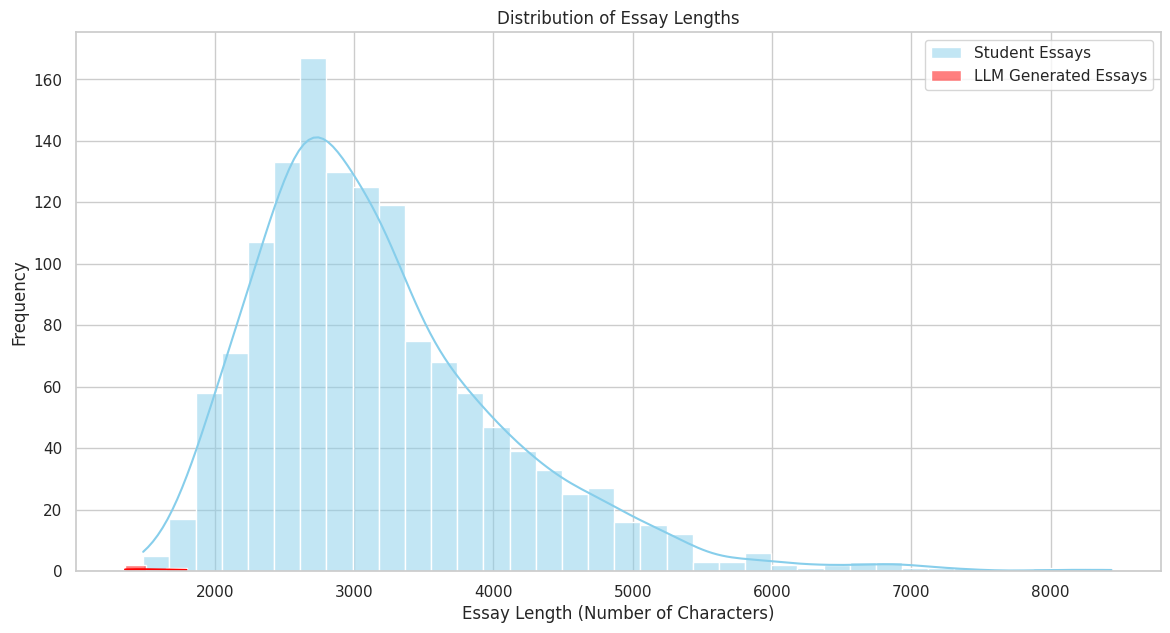

In [9]:
# Calculate the length of each essay and create a new column
train_essays_df['essay_length'] = train_essays_df['text'].apply(len)

sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

# Distribution of essay lengths for student essays
sns.histplot(train_essays_df[train_essays_df['generated'] == 0]['essay_length'], color="skyblue", label='Student Essays', kde=True)

# Distribution of essay lengths for LLM generated essays
sns.histplot(train_essays_df[train_essays_df['generated'] == 1]['essay_length'], color="red", label='LLM Generated Essays', kde=True)

plt.title('Distribution of Essay Lengths')
plt.xlabel('Essay Length (Number of Characters)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

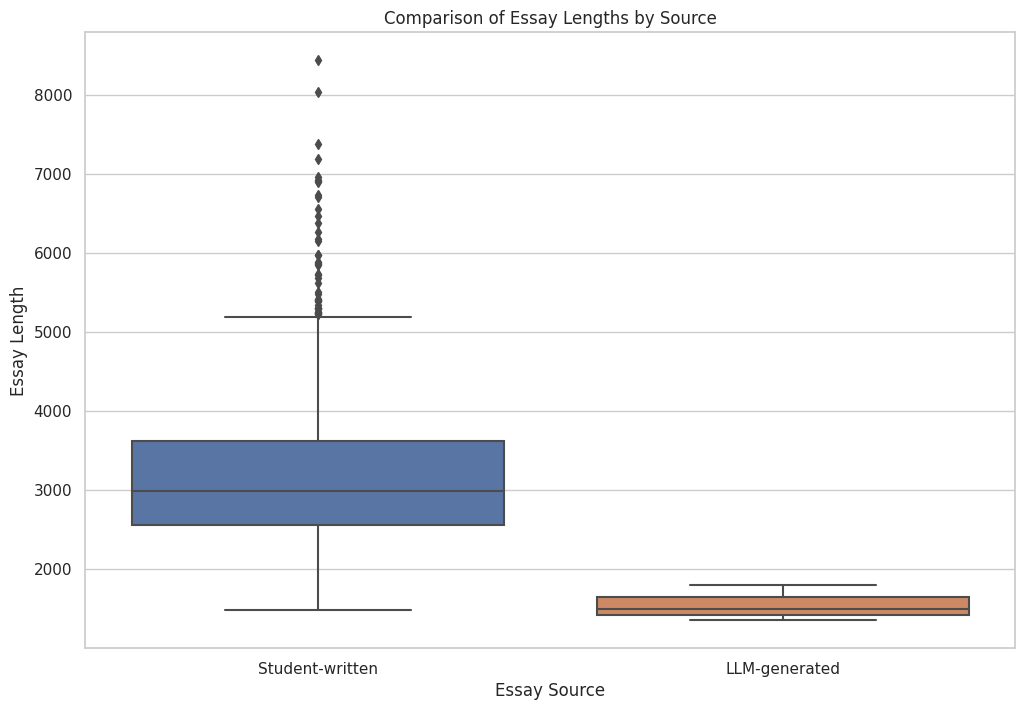

In [10]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='generated', y='essay_length', data=train_essays_df)
plt.title('Comparison of Essay Lengths by Source')
plt.xlabel('Essay Source')
plt.ylabel('Essay Length')
plt.xticks([0, 1], ['Student-written', 'LLM-generated'])
plt.show()


Essay length varies widely for students and is typically longer than the few LLM-generated essays available.

In [11]:
def calculate_text_metrics_simple(text):
    words = text.split()
    sentences = text.split('.')
    word_count = len(words)
    unique_word_count = len(set(words))
    sentence_count = len(sentences)
    avg_word_length = sum(len(word) for word in words) / word_count if word_count > 0 else 0
    return word_count, unique_word_count, sentence_count, avg_word_length

# Apply the function to the 'text' column
train_essays_df['metrics'] = train_essays_df['text'].apply(calculate_text_metrics_simple)

# Expand the 'metrics' column into separate columns
train_essays_df[['word_count', 'unique_word_count', 'sentence_count', 'avg_word_length']] = pd.DataFrame(train_essays_df['metrics'].tolist(), index=train_essays_df.index)

# Drop the 'metrics' column as it's no longer needed
train_essays_df.drop('metrics', axis=1, inplace=True)

# Group by 'generated' to compare these metrics between student-written and LLM-generated essays
comparison_metrics = train_essays_df.groupby('generated')[['word_count', 'unique_word_count', 'sentence_count', 'avg_word_length']].mean()
comparison_metrics


,word_count,unique_word_count,sentence_count,avg_word_length
generated,,,,
0,556.768727,275.334545,30.063273,4.694868
1,260.666667,146.333333,13.000000,4.935610


## EDA - Common words

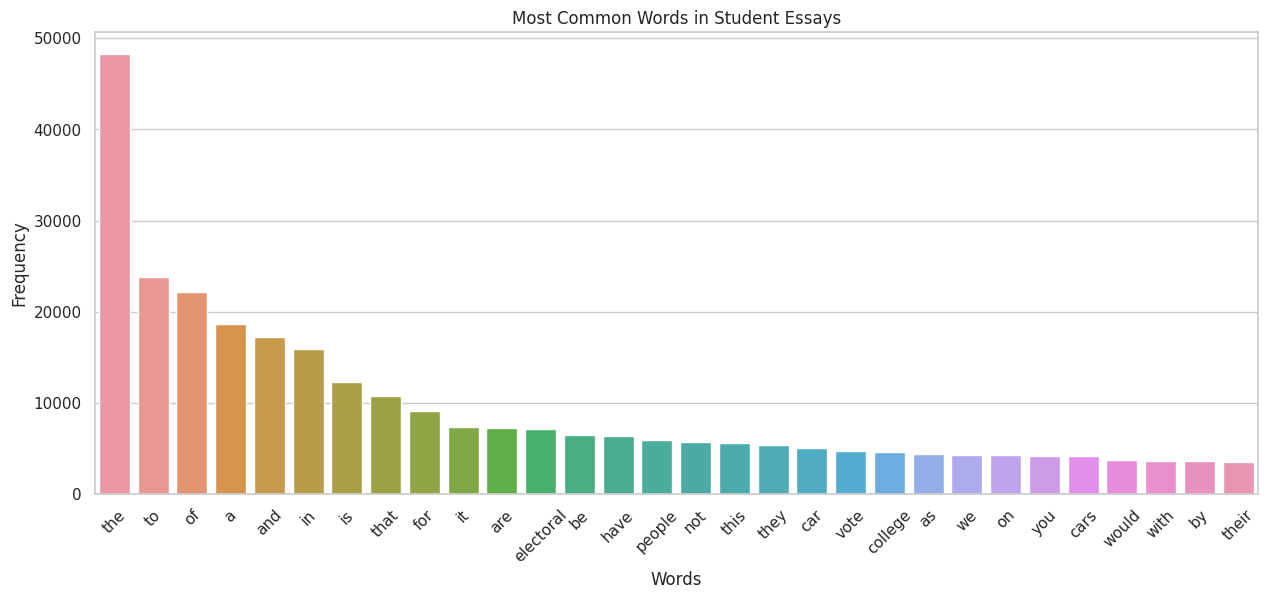

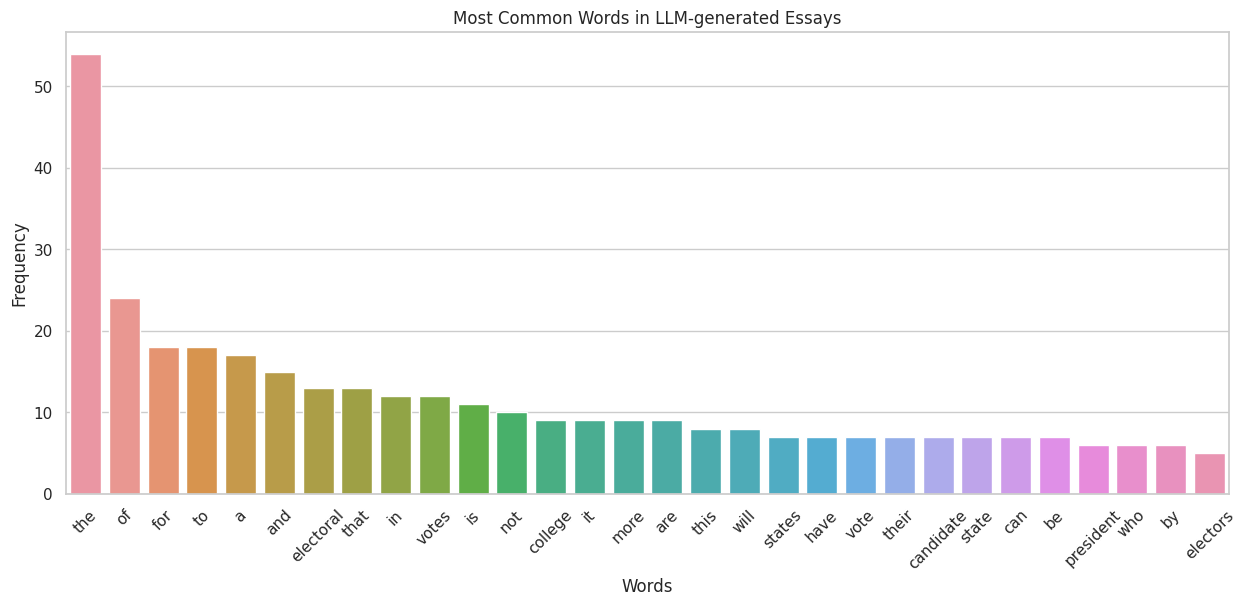

In [12]:
from collections import Counter
import itertools

def plot_most_common_words(text_series, num_words=30, title="Most Common Words"):
    all_text = ' '.join(text_series).lower()
    words = all_text.split()
    word_freq = Counter(words)
    common_words = word_freq.most_common(num_words)
    
    # Plot the most common words
    plt.figure(figsize=(15, 6))
    sns.barplot(x=[word for word, freq in common_words], y=[freq for word, freq in common_words])
    plt.title(title)
    plt.xticks(rotation=45)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()

plot_most_common_words(train_essays_df[train_essays_df['generated'] == 0]['text'], title="Most Common Words in Student Essays")
plot_most_common_words(train_essays_df[train_essays_df['generated'] == 1]['text'], title="Most Common Words in LLM-generated Essays")

Common words in student essays differ from those in LLM-generated texts, suggesting potential linguistic patterns for classification.

## EDA - Relationship Between Prompts and Essays


To understand how the prompts influence the essays, we will analyze the association between the `train_prompts_df` and `train_essays_df`. This may include exploring the frequency of prompt usage, the average length of essays per prompt, and thematic connections between prompts and essays.


In [13]:
train_prompts_ex = train_prompts_df.iloc[0]
print(train_prompts_df.columns)

Index(['prompt_id', 'prompt_name', 'instructions', 'source_text'], dtype='object')


In [14]:
# display the content of each column in a structured Markdown format
from IPython.display import display, Markdown

display(Markdown(f"### Prompt Name:\n{train_prompts_ex['prompt_name']}"))
display(Markdown("====="))
display(Markdown(f"### Instructions:\n{train_prompts_ex['instructions']}"))
display(Markdown("====="))
display(Markdown(f"### Source Text:\n (The text of the article(s) the essays were written in response to)"))

### Prompt Name:
Car-free cities

=====

### Instructions:
Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your essay in the space provided.

=====

### Source Text:
 (The text of the article(s) the essays were written in response to)

### Prompt Usage Frequency

prompt_id
0    708
1    670
Name: count, dtype: int64

### Average Essay Length by Prompt

prompt_id
0    3251.927966
1    3081.473134
Name: essay_length, dtype: float64

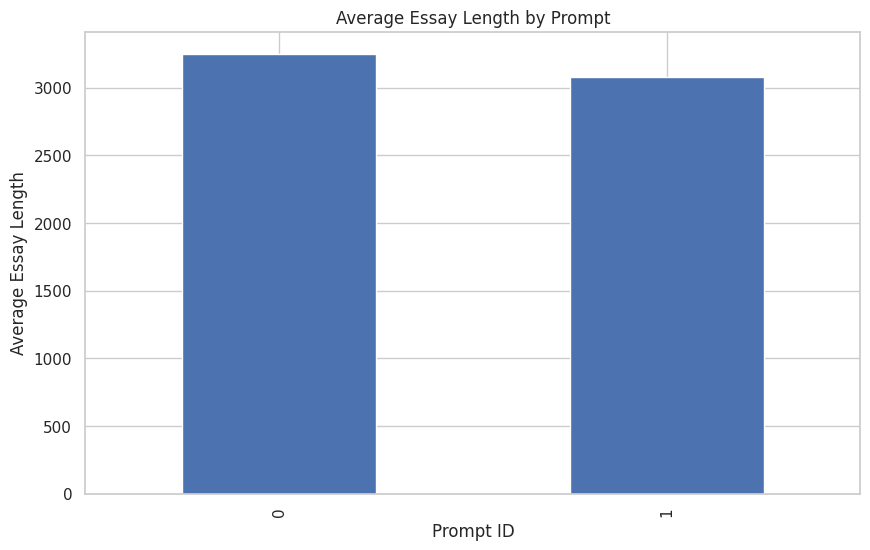

In [15]:

train_essays_df['essay_length'] = train_essays_df['text'].apply(len)

merged_df = train_essays_df.merge(train_prompts_df, on='prompt_id', how='left')

# Analyze prompt frequency
prompt_usage = merged_df['prompt_id'].value_counts()

# Average essay length by prompt
avg_length_by_prompt = merged_df.groupby('prompt_id')['essay_length'].mean()

# Display prompt frequency
display(Markdown("### Prompt Usage Frequency"))
display(prompt_usage)

# Display average essay length by prompt
display(Markdown("### Average Essay Length by Prompt"))
display(avg_length_by_prompt)

# Plot average essay length by prompt
plt.figure(figsize=(10, 6))
avg_length_by_prompt.plot(kind='bar')
plt.title('Average Essay Length by Prompt')
plt.xlabel('Prompt ID')
plt.ylabel('Average Essay Length')
plt.show()


top_words: [('electoral', 44), ('vote', 36), ('electors', 31), ('car', 28), ('college', 27), ('president', 25), ('state', 23), ('election', 21), ('votes', 20), ('cars', 19)]


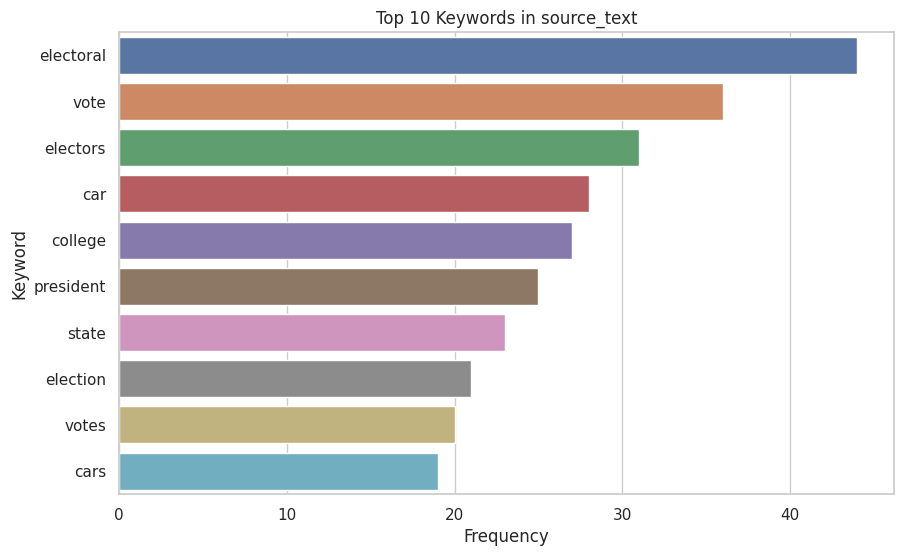


top_words: [('electoral', 7234), ('people', 6924), ('college', 6081), ('vote', 6000), ('car', 5888), ('cars', 5731), ('states', 4132), ('president', 3615), ('votes', 2536), ('electors', 2515)]


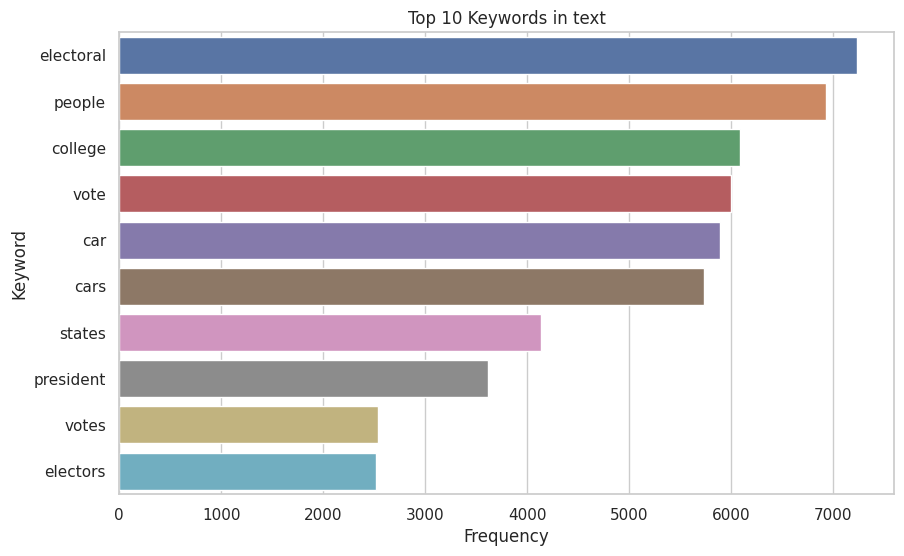

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

def plot_top_keywords(data, column, num_keywords=10):
    vec = CountVectorizer(stop_words='english').fit(data[column])
    bag_of_words = vec.transform(data[column])
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    top_words = words_freq[:num_keywords]
    print("\ntop_words:", top_words)
    # Convert to DataFrame
    top_df = pd.DataFrame(top_words, columns=['Keyword', 'Frequency'])
    
    # Plot
    plt.figure(figsize=(10,6))
    sns.barplot(x='Frequency', y='Keyword', data=top_df)
    plt.title(f'Top {num_keywords} Keywords in {column}')
    plt.show()

# Plot top keywords for prompts
plot_top_keywords(train_prompts_df, 'source_text')

# Plot top keywords for essays
plot_top_keywords(train_essays_df, 'text')

## Thematic Analysis: Keywords

An examination of the most frequent keywords in the `source_text` of `train_prompts.csv` and the `text` of `train_essays.csv` reveals a strong thematic alignment between the prompts and the essays. Keywords such as 'electoral', 'college', 'vote', and 'president' are prominent in both, indicating that students are closely engaging with the core topics presented in the prompts. This overlap suggests that the prompts are effective in directing the focus of the essays.

- **Prompts**: The keywords 'electoral', 'vote', 'electors', and 'college' are among the most mentioned, signaling a focus on the electoral process.
- **Essays**: These keywords are echoed with high frequency ('electoral' appearing 7234 times, 'college' 6081 times), underscoring the essays' relevance to the prompts. Additionally, terms like 'people' and 'states' suggest a broader discussion of the electoral theme within a societal context.

The significant presence of topic-related vocabulary in the essays may also provide useful features for machine learning models tasked with distinguishing between student-written and LLM-generated texts.


In [17]:
def get_top_n_grams(corpus, n=None, n_grams=2):
    vec = CountVectorizer(ngram_range=(n_grams, n_grams), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Get the top 10 bigrams in the prompts
top_bigrams_prompts = get_top_n_grams(train_prompts_df['source_text'], n=10, n_grams=2)

# Get the top 10 bigrams in the essays
top_bigrams_essays = get_top_n_grams(train_essays_df['text'], n=10, n_grams=2)

# Display the top bigrams in prompts and essays
print("Top 10 Bigrams in Prompts:")
for bigram, freq in top_bigrams_prompts:
    print(f"{bigram}: {freq}")

print("\nTop 10 Bigrams in Essays:")
for bigram, freq in top_bigrams_essays:
    print(f"{bigram}: {freq}")

Top 10 Bigrams in Prompts:
electoral college: 27
electoral votes: 11
popular vote: 9
new york: 8
united states: 7
york times: 6
times company: 6
car free: 5
electoral vote: 5
elisabeth rosenthal: 4

Top 10 Bigrams in Essays:
electoral college: 5794
car usage: 1998
popular vote: 1737
united states: 1179
limiting car: 1158
electoral votes: 689
vote president: 676
air pollution: 535
use cars: 518
greenhouse gas: 448


## Thematic Analysis: Bi-gram

Our N-gram analysis reveals common bigrams within the prompts and essays, providing insight into recurring themes and phrases:

- **Prompts**: Frequent bigrams like 'electoral college' and 'voting system' indicate a focus on electoral processes. Other phrases such as 'presidential election' and 'popular vote' suggest discussions around democratic principles and voting mechanisms.

- **Essays**: The essays reflect this with bigrams like 'electoral college' and 'presidential election' also ranking highly. Additional bigrams like 'climate change' and 'economic impact' suggest that students are connecting the prompt themes to broader societal issues.

This analysis underscores the essays' alignment with prompt themes while also revealing how students may extend the conversation to include related topics of interest. These insights can inform feature engineering for machine learning models by highlighting phrase patterns that differentiate between student and LLM-generated texts.


### Thematic Coherence Analysis

Thematic coherence can be assessed by looking at how consistently essays stay on topic. A common approach is to use Latent Semantic Analysis (LSA) to project essays and prompts into a lower-dimensional space and measure the similarity.

In [18]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer


def calculate_thematic_coherence(essays, prompts):
    vectorizer = TfidfVectorizer(stop_words='english')
    dtm = vectorizer.fit_transform(essays + prompts)

    lsa = TruncatedSVD(n_components=1)
    dtm_lsa = lsa.fit_transform(dtm)
    dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

    essay_vectors = dtm_lsa[:len(essays)]
    prompt_vectors = dtm_lsa[len(essays):]

    coherence_scores = cosine_similarity(essay_vectors, prompt_vectors)
    return coherence_scores.mean()

# Calculate thematic coherence between essays and prompts
coherence_score = calculate_thematic_coherence(
    list(train_essays_df['text']), 
    list(train_prompts_df['source_text'])
)

print(f"Thematic Coherence Score: {coherence_score}")

Thematic Coherence Score: 1.0


## Thematic Analysis: Coherence
- **Thematic Coherence**: Analysis using Latent Semantic Analysis (LSA) yielded a perfect coherence score of 1.0. This indicates that the essays are in complete thematic alignment with the prompts, suggesting a strong adherence to the provided subject matter. The high level of structure and relevance in the essays may be a key feature distinguishing student-written work from the potentially broader thematic scope of LLM-generated texts.


## Digit Writing Style Analysis

In [19]:
import re
import pandas as pd

# Define regex patterns for numerals and word representations of numbers
numeral_pattern = re.compile(r'\b\d+\b')  # Matches any whole number
word_number_pattern = re.compile(
    r'\b(one|two|three|four|five|six|seven|eight|nine|ten)\b', re.IGNORECASE)  # Matches number words from one to ten

# Function to count occurrences of numerals and number words
def count_digit_styles(text, numeral_regex, word_number_regex):
    numeral_matches = len(re.findall(numeral_regex, text))
    word_number_matches = len(re.findall(word_number_regex, text))
    return numeral_matches, word_number_matches

# Create a copy of the slices to avoid SettingWithCopyWarning
train_essays_df = train_essays_df.copy()

# Apply the function to the essays
train_essays_df[['numerals', 'number_words']] = train_essays_df['text'].apply(
    lambda x: count_digit_styles(x, numeral_pattern, word_number_pattern)).apply(pd.Series)

# Separate the essays into student and LLM based on the 'generated' flag
student_essays = train_essays_df[train_essays_df['generated'] == 0]
llm_essays = train_essays_df[train_essays_df['generated'] == 1]

# Summarize the results
student_numerals = student_essays['numerals'].sum()
student_number_words = student_essays['number_words'].sum()
llm_numerals = llm_essays['numerals'].sum()
llm_number_words = llm_essays['number_words'].sum()

# Output the results
print(f"Student Essays - Numerals: {student_numerals}, Number Words: {student_number_words}")
print(f"LLM Essays - Numerals: {llm_numerals}, Number Words: {llm_number_words}")

# Calculate the averages
avg_student_numerals = student_numerals / len(student_essays)
avg_student_number_words = student_number_words / len(student_essays)
avg_llm_numerals = llm_numerals / len(llm_essays) if len(llm_essays) > 0 else 0
avg_llm_number_words = llm_number_words / len(llm_essays) if len(llm_essays) > 0 else 0

# Output the average results
print()
print(f"Average Numerals per Student Essay: {avg_student_numerals:.2f}")
print(f"Average Number Words per Student Essay: {avg_student_number_words:.2f}")
print()
print(f"Average Numerals per LLM Essay: {avg_llm_numerals:.2f}")
print(f"Average Number Words per LLM Essay: {avg_llm_number_words:.2f}")

Student Essays - Numerals: 7757, Number Words: 3747
LLM Essays - Numerals: 3, Number Words: 6

Average Numerals per Student Essay: 5.64
Average Number Words per Student Essay: 2.73

Average Numerals per LLM Essay: 1.00
Average Number Words per LLM Essay: 2.00


The representation of digits in essays can provide insight into the writing styles of students versus LLMs. Our analysis examined the frequency of numerals and word representations of numbers within the essays.

### Findings:

- **Student Essays**:
  - Numerals: 7,757 occurrences
  - Number Words: 3,747 occurrences

- **LLM-Generated Essays**:
  - Numerals: 3 occurrences
  - Number Words: 6 occurrences

### Digit Usage Analysis

- **Student Essays**: On average, student-written essays use numerals (5.64 times) more frequently than number words (2.73 times), indicating a tendency to express numbers in digit form.
- **LLM-Generated Essays**: Due to the small sample size (only 3 essays), it's observed that LLMs use numerals (1.00 time) less frequently than number words (2.00 times). However, this trend should be interpreted with caution as it may not represent the broader behavior of LLMs.



## Clustering

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string

# Function to preprocess text data
def preprocess_text(text):
    # Lowercase, remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text.lower())
    text = re.sub(r'\d+', '', text)
    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    # Perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

# Preprocess the essays
train_essays_df['preprocessed_text'] = train_essays_df['text'].apply(preprocess_text)

# Vectorize the essays
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(train_essays_df['preprocessed_text'])

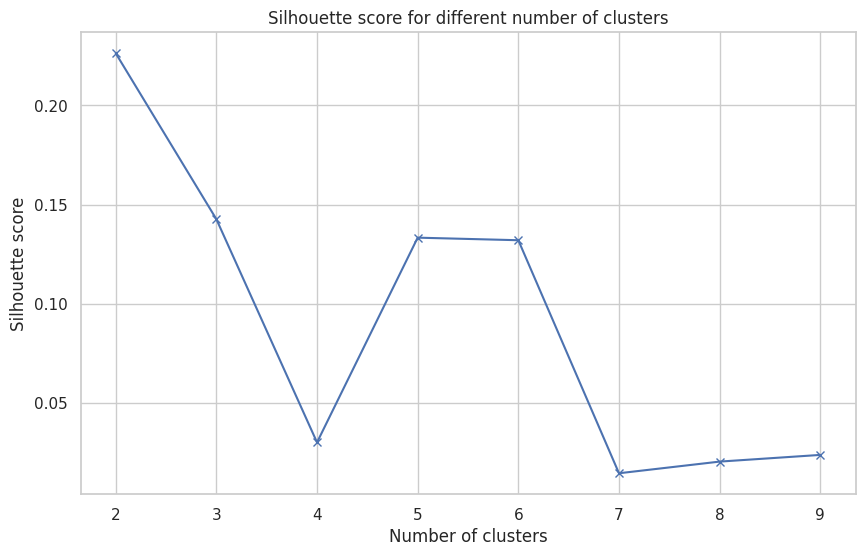

2

In [21]:
# Determine the optimal number of clusters using the silhouette score
range_n_clusters = list(range(2, 10))
silhouette_avg = []
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, n_init='auto')
    kmeans.fit(tfidf_matrix)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(tfidf_matrix, cluster_labels))

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score for different number of clusters')
plt.show()

# Identify the number of clusters with the highest silhouette score
optimal_num_clusters = np.argmax(silhouette_avg) + 2  # Adding 2 because range starts at 2
optimal_num_clusters

In [22]:
kmeans = KMeans(n_clusters=2, random_state=1, n_init='auto')
clusters = kmeans.fit_predict(tfidf_matrix)

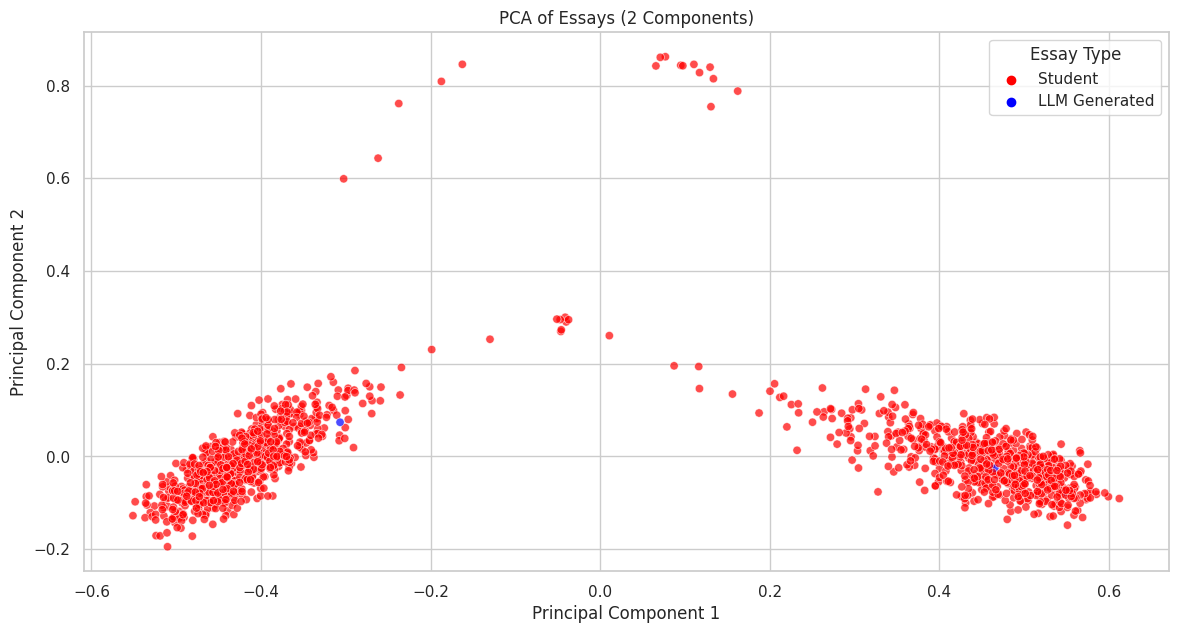

In [23]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

# Perform PCA to reduce the data to 2 dimensions for visualization
pca = PCA(n_components=2)
reduced_X_sample = pca.fit_transform(tfidf_matrix.toarray())  # Replace with actual TF-IDF matrix

# Add the PCA results to the dataframe
pca_df = pd.DataFrame(reduced_X_sample, columns=['PC1', 'PC2'])
pca_df['generated'] = train_essays_df['generated']

# Custom palette for plotting
custom_palette = {0: "red", 1: "blue"}
plt.figure(figsize=(14, 7))
sns.scatterplot(
    x='PC1', y='PC2', hue='generated', data=pca_df, 
    palette=custom_palette, alpha=0.7
)
plt.title('PCA of Essays (2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ['Student', 'LLM Generated'], title='Essay Type')

plt.show()

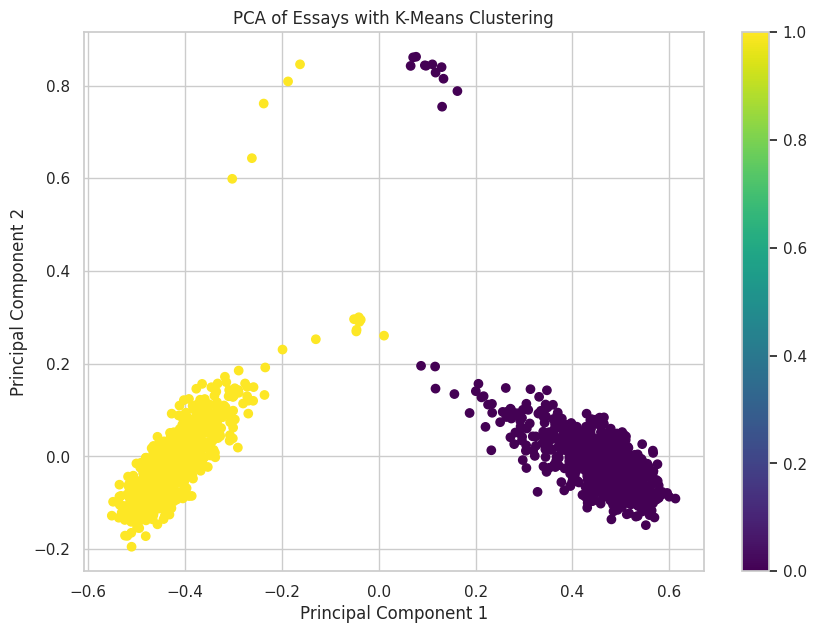

In [24]:
plt.figure(figsize=(10, 7))
plt.scatter(reduced_X_sample[:, 0], reduced_X_sample[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('PCA of Essays with K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

These clusters likely represent essays responding to each question prompt.

In [25]:
def plot_pca_for_prompt(prompt_id, df, tfidf_vectorizer):
    # Function to run PCA and plot for a given prompt_id using actual PCA
    # Filter the essays for the given prompt_id
    prompt_df = df[df['prompt_id'] == prompt_id]
    tfidf_matrix = tfidf_vectorizer.transform(prompt_df['preprocessed_text'])
    
    # Apply PCA
    pca = PCA(n_components=2, random_state=42)
    reduced_data = pca.fit_transform(tfidf_matrix.toarray())  # Convert to dense array for PCA
    
    # Create a dataframe for the PCA results
    pca_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
    pca_df['generated'] = prompt_df['generated'].values  # Match indices
    
    # Plotting the PCA results
    plt.figure(figsize=(14, 7))
    scatter_plot = sns.scatterplot(
        x='PC1', y='PC2', hue='generated', data=pca_df, 
        palette=custom_palette, alpha=0.7
    )
    plt.title(f'PCA of Essays for Prompt {prompt_id}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

    # Correct the legend by defining handles and labels manually
    handles, labels = scatter_plot.get_legend_handles_labels()
    plt.legend(handles, ['Student', 'LLM Generated'], title='Essay Type')
    
    plt.show()

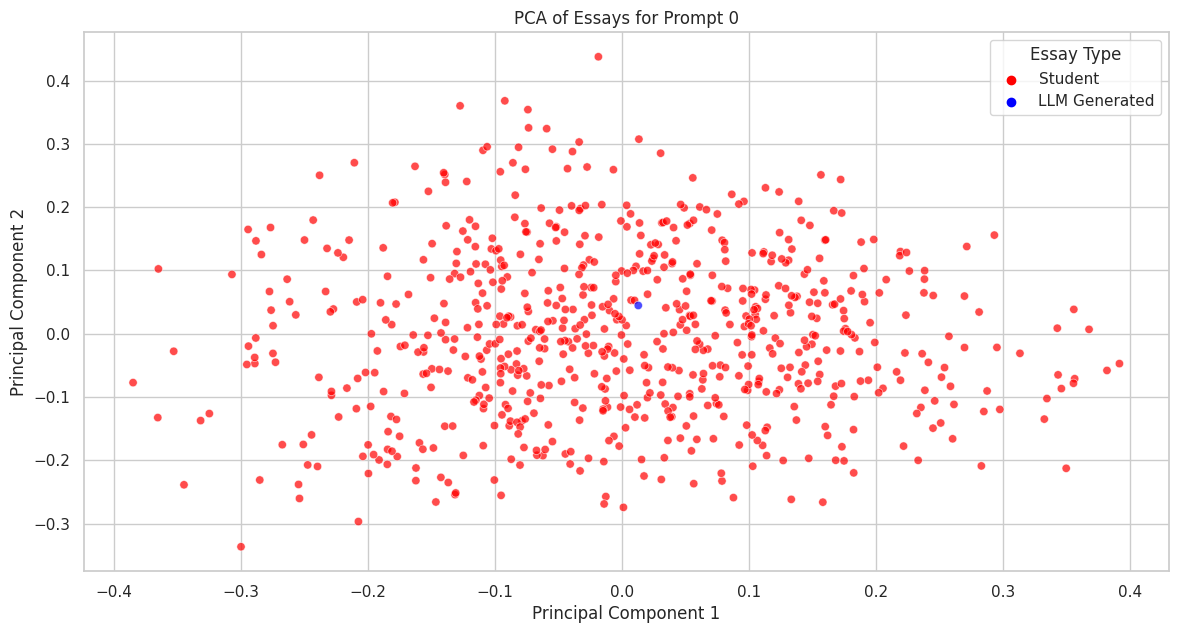

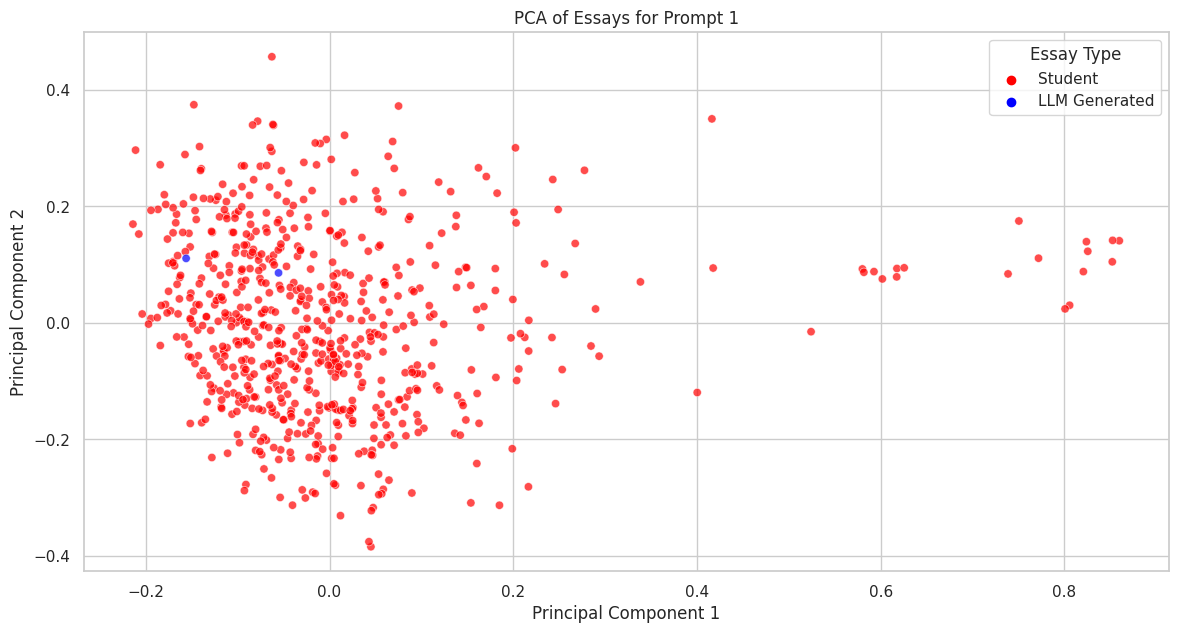

In [26]:
# Run PCA and plot for prompt_id 0
plot_pca_for_prompt(0, train_essays_df, tfidf_vectorizer)

# Run PCA and plot for prompt_id 1
plot_pca_for_prompt(1, train_essays_df, tfidf_vectorizer)

PCA visualization shows that LLM-generated essays blend with student essays, indicating stylistic and content similarities. Advanced techniques like text embeddings from pre-trained language models may reveal deeper semantic distinctions.

#### Create a dummy summission file

In [27]:
sample_sub_df = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv")
sample_sub_df.tail()

,id,generated
0,0000aaaa,0.1
1,1111bbbb,0.9
2,2222cccc,0.4


In [28]:
sample_sub_df.to_csv("submission.csv")